In [53]:
import camelot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [54]:
directory = os.getcwd()
path = directory + '\statements'
filenames = os.listdir(path)
filenames

['statement_1.pdf']

In [55]:
concat = []
for pdf in range(len(filenames)):
    tables = camelot.read_pdf(f'statements/{filenames[pdf]}', flavor='stream', pages='all')

    ## create concat df
    temp = tables[0].df.copy()

    ## concatenate all tables into one
    for i in range(1, len(tables)):
        temp = pd.concat([temp, tables[i].df])

    concat.append(temp)
concat = pd.concat(concat)


## filter out nonsensical data
concat = concat[~concat.apply(lambda row: row.astype(str).str.contains('about:blank')).any(axis=1)]

## reset index of df
concat = concat.reset_index(drop=True)

if concat.shape[-1] == 7:
    concat = concat.drop(concat.columns[-1], axis=1)

## rename columns
concat.columns = ['Date', 'Code', 'Reference', 'Debit', 'Credit', 'Extra']

## handle bad formatting
for row in range(len(concat)):
    value = concat.at[row, 'Credit']
    extraVal = concat.at[row, 'Extra']
    
    if value != '':
        concat.at[row, 'Debit'] = value
        concat.at[row, 'Credit'] = ''
    
    if extraVal != '':
        concat.at[row, 'Credit'] = extraVal
        concat.at[row, 'Extra'] = ''
        
## drop useless column
concat = concat.drop(columns=['Extra'])

firstCell = concat.at[0, 'Date']
secondCell = concat.at[1, 'Debit']
thirdCell = concat.at[2, 'Debit']
fourthCell = concat.at[3, 'Debit']

if firstCell.split(' ')[0] == 'Transaction':
    concat = concat.drop([0])
    
if secondCell == 'Download':
    concat = concat.drop([1])
    
if thirdCell == 'Debit':
    concat = concat.drop([2])
    
if fourthCell == '(Withdrawal)':
    concat = concat.drop([3])
    
concat = concat.reset_index(drop=True)

In [56]:
concat['Type'] = ''
concat = concat.reindex(columns=['Date', 'Code', 'Type', 'Reference', 'Debit', 'Credit'])

In [38]:
concat

,Date,Code,Type,Reference,Debit,Credit
0,26 Nov 2022,POS,,Point-of-Sale Transaction,S$23.25,
1,,,,"43375097,JOLLIBEE NETS",,
2,25 Nov 2022,POS,,Point-of-Sale Transaction,S$1.20,
3,,,,"43375097,CANOPY COFFEE CLUB",,
4,,,,NETS,,
...,...,...,...,...,...,...
585,,,,BOOST JUICE RCS SI NG 30AUG,,
586,,,,4628-4500-4337-5097,,
587,29 Aug 2022,ITR,,Funds Transfer,,S$80.00
588,,,,009-1-024105 : I-BANK,,


In [57]:
for a in range(len(concat)):
    code = concat.at[a, 'Code']
    steps = 0
    
    if code != '':
        addArr = []
        index = a + 1
        
        while True:
            if index > len(concat)-1:
                break
                
            check = concat.at[index, 'Code']
            if check == '':
                addArr.append(concat.at[index, 'Reference'])
                steps += 1
                index += 1
            else:
                break
            
        for step in range(steps):
            if concat.at[a, 'Reference'][-1] == '-' or concat.at[a, 'Reference'][-1].isdigit() == True:
                concat.at[a, 'Reference'] += concat.at[a+step+1, 'Reference']
            else:
                concat.at[a, 'Reference'] += ' ' + concat.at[a+step+1, 'Reference']
                
            concat.at[a+step+1, 'Reference'] = ''

In [58]:
## remove all empty rows
concat = concat.loc[~(concat == '').all(axis=1)]
concat = concat.reset_index(drop=True)

In [59]:
if concat.at[concat.shape[0]-1, 'Debit'] != '' and concat.at[concat.shape[0]-1, 'Credit'] != '':
    DrBal = concat.at[concat.shape[0]-1, 'Debit']
    CrBal = concat.at[concat.shape[0]-1, 'Credit']
    concat = concat.drop(concat.index[-1])

In [60]:
concat

,Date,Code,Type,Reference,Debit,Credit
0,26 Nov 2022,POS,,"Point-of-Sale Transaction 43375097,JOLLIBEE NETS",S$23.25,
1,25 Nov 2022,POS,,"Point-of-Sale Transaction 43375097,CANOPY COFF...",S$1.20,
2,25 Nov 2022,MST,,Debit Card Transaction KOUFU PTE LTD SI NG 24N...,S$23.30,
3,23 Nov 2022,MST,,Debit Card Transaction NET*NETSMM SI NG 21NOV ...,S$7.20,
4,23 Nov 2022,MST,,Debit Card Transaction DIN TAI FUNG-JEM SI NG ...,S$57.20,
...,...,...,...,...,...,...
99,01 Sep 2022,MST,,Debit Card Transaction IPPUDO - RAFFLES CITY S...,S$68.68,
100,31 Aug 2022,INT,,Interest Earned,,S$0.01
101,31 Aug 2022,ITR,,Funds Transfer 009-1-024105 : I-BANK,,S$17.00
102,31 Aug 2022,MST,,Debit Card Transaction BOOST JUICE RCS SI NG 3...,S$11.00,


In [61]:
for TYPE in range(len(concat)):
    code = concat.at[TYPE, 'Code']
    
    if code == 'MST':
        concat.at[TYPE, 'Type'] = 'Card Transaction'
        
    if code == 'ITR' or code == 'ICT':
        concat.at[TYPE, 'Type'] = 'Funds Transfer'
        
    if code == 'POS':
        concat.at[TYPE, 'Type'] = 'Point-Of-Sale'
        
    if code == 'INT':
        concat.at[TYPE, 'Type'] = 'Interest Earned'

In [62]:
concat = concat.reindex(index=concat.index[::-1])
concat.reset_index(drop=True)

,Date,Code,Type,Reference,Debit,Credit
0,29 Aug 2022,ITR,Funds Transfer,Funds Transfer 009-1-024105 : I-BANK,,S$80.00
1,31 Aug 2022,MST,Card Transaction,Debit Card Transaction BOOST JUICE RCS SI NG 3...,S$11.00,
2,31 Aug 2022,ITR,Funds Transfer,Funds Transfer 009-1-024105 : I-BANK,,S$17.00
3,31 Aug 2022,INT,Interest Earned,Interest Earned,,S$0.01
4,01 Sep 2022,MST,Card Transaction,Debit Card Transaction IPPUDO - RAFFLES CITY S...,S$68.68,
...,...,...,...,...,...,...
99,23 Nov 2022,MST,Card Transaction,Debit Card Transaction DIN TAI FUNG-JEM SI NG ...,S$57.20,
100,23 Nov 2022,MST,Card Transaction,Debit Card Transaction NET*NETSMM SI NG 21NOV ...,S$7.20,
101,25 Nov 2022,MST,Card Transaction,Debit Card Transaction KOUFU PTE LTD SI NG 24N...,S$23.30,
102,25 Nov 2022,POS,Point-Of-Sale,"Point-of-Sale Transaction 43375097,CANOPY COFF...",S$1.20,


In [63]:
concat = concat.loc[~((concat['Date'] == 'Date') & (concat['Code'] == 'Code'))]
concat = concat.loc[~((concat['Debit'] == 'Download') & (concat['Credit'] == 'Print'))]
concat = concat.loc[~((concat['Debit'] == '(Withdrawal)') & concat['Credit'] == '(Deposit)')]
concat = concat.replace('', np.nan)
concat = concat.dropna(thresh=len(concat.columns) - 3)
concat = concat.reset_index(drop=True)
concat = concat.loc[~((concat['Date'].str.contains('Transaction History')))]
concat = concat.reset_index(drop=True)

In [64]:
concat.to_csv('check.csv')

In [65]:
concat['Balance'] = ''
final = 204.47
concat.at[concat.shape[0]-1, 'Balance'] = 'S$' + str(204.47)
index = concat.shape[0]-2

for agg in range(len(concat)):

    if concat.at[index, 'Debit'] != '':
        if isinstance(concat.at[index, 'Debit'], float) == False:
            update = final - float(concat.at[index, 'Debit'][2:])
            concat.at[index, 'Balance'] = 'S$' + str(round(update, 2))

    if concat.at[index, 'Credit'] != '':
        if isinstance(concat.at[index, 'Credit'], float) == False:
            update = final + float(concat.at[index, 'Credit'][2:])
            concat.at[index, 'Balance'] = 'S$' + str(round(update, 2))


    if index != 0:
        index -= 1

In [66]:
concat.to_csv('check.csv')

In [67]:
def pie():
    TYPE = concat['Type']
    counts = TYPE.value_counts()
    names = counts.index.tolist()
    
    plt.pie(counts, labels=names, autopct='%1.1f%%')
    plt.legend()
    plt.show()
    
def totalDrCr():
    dr = float(DrBal[2:].replace(',', ''))
    cr = float(CrBal[2:].replace(',', ''))

    vals = [dr, cr]
    names = ['Debit', 'Credit']
    plt.bar(x=names, height=vals)
    plt.legend()
    plt.show()

def timeSeries():
    line = concat['']


def saveToCSV():
    saveDF = concat.copy()
    date = saveDF.at[saveDF.shape[0]-1, 'Date']

    newRow = {
        'Date': date, 
        'Code': 'TTL', 
        'Type': 'Running Total', 
        'Reference': 'Total Dr/Cr',
        'Debit': DrBal,
        'Credit': CrBal}
    
    saveDF = saveDF.append(newRow, ignore_index=True)
    saveDF.to_excel('parsed.xlsx')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


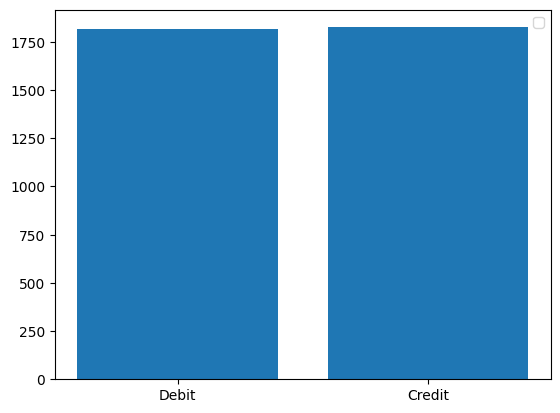

In [68]:
totalDrCr()

In [69]:
import plotly.io as pio
pio.renderers.default = "vscode"
import plotly.express as px
fig = px.pie(concat, 'Type')
fig.show()

In [52]:
saveToCSV()

C:\Users\rutsm\AppData\Local\Temp\ipykernel_2072\3571749736.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

